In [115]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

In [116]:
df_path = '../../data/whisper-small-runs.csv'
df = pd.read_csv(df_path)
df.head()

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.0,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2.0,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2
3,3.0,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3
4,4.0,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4


In [117]:
df['experiment_name'].unique()

array(['whisper-small-tira', 'whisper-small-tira-all',
       'whisper-small-tira-all-clean',
       'whisper-small-tira-all-clean-lid-alpha-0.2',
       'whisper-small-tira-all-clean-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-all-ewc-lambda-1',
       'whisper-small-tira-all-lid-alpha-0.2',
       'whisper-small-tira-all-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-eng', 'whisper-small-tira-eng-cs',
       'whisper-small-tira-eng-cs-20-80-large',
       'whisper-small-tira-eng-cs-20-80-large-ewc-lambda-1',
       'whisper-small-tira-eng-cs-20-80-large-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-20-80-small',
       'whisper-small-tira-eng-cs-20-80-small-ewc-lambda-1',
       'whisper-small-tira-eng-cs-20-80-small-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-50-50',
       'whisper-small-tira-eng-cs-50-50-ewc-lambda-1',
       'whisper-small-tira-eng-cs-50-50-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-clean',
       'whisper-small-tira-eng-cs-c

In [118]:
# get more detailed colnames
get_metric = lambda s: 'cer' if s.endswith('cer') else 'wer' if s.endswith('wer') else ''
df['metric']=df['tag'].apply(get_metric)
df['metric'].value_counts()

metric
       9361
cer    1434
wer    1434
Name: count, dtype: int64

In [119]:
df

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch,metric
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,cer
1,1.0,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1,cer
2,2.0,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2,cer
3,3.0,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3,cer
4,4.0,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4,cer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,NaN,6288,eval_steps_per_second,0.049000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,6,
12225,NaN,7336,eval_steps_per_second,0.038000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,7,
12226,NaN,8384,eval_steps_per_second,0.172000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,8,
12227,NaN,9432,eval_steps_per_second,0.034000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,9,


In [120]:
df['epoch']=0
epoch_mask = df['tag'].str.contains('epoch')
for i, row in df[epoch_mask].iterrows():
    step_mask = df['step']==row['step']
    exp_mask = df['experiment_name']==row['experiment_name']
    df.loc[step_mask & exp_mask, 'epoch'] = int(row['value'])
df

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch,metric
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,cer
1,1.0,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1,cer
2,2.0,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2,cer
3,3.0,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3,cer
4,4.0,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4,cer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,NaN,6288,eval_steps_per_second,0.049000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,6,
12225,NaN,7336,eval_steps_per_second,0.038000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,7,
12226,NaN,8384,eval_steps_per_second,0.172000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,8,
12227,NaN,9432,eval_steps_per_second,0.034000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,9,


In [121]:
unique_datasets = ['fl_en', 'HH20210312', 'HH20210913', 'tira-clean-split', 'sasoc-cs', 'sasoc-zul', 'sasoc-en', 'nchlt_zul', 'nchlt_eng', 'tira_cs']

def get_dataset(s):
    for dataset in unique_datasets:
        if dataset in s:
            return dataset


df['dataset']=df['tag'].apply(get_dataset)
df['dataset'].value_counts()

dataset
sasoc-cs     2388
fl_en        2052
nchlt_zul    1572
Name: count, dtype: int64

In [122]:
# so we can compare no LID loss to using LID loss
df['lid_loss_alpha']=df['lid_loss_alpha'].fillna(0)
df['ewc_lambda']=df['ewc_lambda'].fillna(0)

In [123]:
df['ewc']=df['ewc_lambda']>0
df['lid_loss']=df['lid_loss_alpha']>0
df['regularization']='none'
df.loc[df['ewc'], 'regularization']='ewc'
df.loc[df['lid_loss'], 'regularization']='lid_loss'
df.loc[df['ewc'] & df['lid_loss'], 'regularization']='ewc+lid_loss'

In [124]:
df['train_data']='tira'
df.loc[df['experiment_name'].str.contains('tira-eng'), 'train_data']='tira-eng'
df.loc[df['experiment_name'].str.contains('tira-eng-50pct'), 'train_data']='tira-eng-50pct'
df.loc[df['experiment_name'].str.contains('tira-eng-cs'), 'train_data']='misc'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-small'), 'train_data']='tira-eng-cs-20-80-small'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-large'), 'train_data']='tira-eng-cs-20-80-large'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-50-50-large'), 'train_data']='tira-eng-cs-50-50'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-clean'), 'train_data']='tira-eng-cs-clean'
df.loc[df['experiment_name'].str.contains('tira-all'), 'train_data']='tira-all'
df.loc[df['experiment_name'].str.contains('tira-all-clean'), 'train_data']='tira-all-clean'
df.loc[df['experiment_name'].str.contains('tira-all-long'), 'train_data']='tira-all-long'

df.loc[df['experiment_name'].str.contains('zulu'), 'train_data']='zulu'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng'), 'train_data']='zulu+eng'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng-50pct'), 'train_data']='zulu+eng-50pct'
df.loc[df['experiment_name'].str.contains('zulu-eng-cs'), 'train_data']='zulu-eng-cs'
df.loc[df['experiment_name'].str.contains('zulu-eng-all'), 'train_data']='zulu-eng-all'

df['train_data'].value_counts()

train_data
zulu-eng-cs                2704
zulu+eng                   2500
zulu                       2096
tira-all                    808
misc                        742
zulu-eng-all                729
tira-all-clean              546
tira                        536
tira-eng                    534
tira-eng-cs-20-80-large     318
tira-eng-cs-20-80-small     270
tira-eng-cs-clean           258
zulu+eng-50pct              188
Name: count, dtype: int64

In [125]:
df.loc[
    df['experiment_name'].str.contains('tira')&df['tag'].str.contains('eval')&df['dataset'].isna(),
    'dataset'
] = 'tira-cs'
df['dataset'].value_counts()

dataset
sasoc-cs     2388
fl_en        2052
tira-cs      1980
nchlt_zul    1572
Name: count, dtype: int64

In [126]:
df.loc[
    (df['train_data']=='zulu-eng-all')&df['tag'].str.contains('eval')&df['dataset'].isna(),
    'dataset'
] = 'sasoc-cs'
df['dataset'].value_counts()

dataset
sasoc-cs     2880
fl_en        2052
tira-cs      1980
nchlt_zul    1572
Name: count, dtype: int64

In [127]:
df=df.sort_values('step')
for experiment in df['experiment_name'].unique():
    for tag in df['tag'].unique():
        if 'loss' not in tag:
            continue
        loss_mask = df['tag']==tag
        experiment_mask = df['experiment_name']==experiment
        loss_diff = np.diff(df.loc[experiment_mask&loss_mask, 'value'])
        loss_diff = np.insert(loss_diff, 0, 0)
        df.loc[experiment_mask&loss_mask, 'loss_diff']=loss_diff
df.head()


,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,0.0,False,...,NaN,NaN,0,cer,tira-cs,False,False,none,tira,NaN
5536,372.0,0,eval/sasoc-cs-en+sw_cer,0.916962,whisper-small-zulu-eng-cs-ewc-lambda-1,1900-02-05 18:49:47,NaN,NaN,0.0,False,...,NaN,NaN,0,cer,sasoc-cs,True,False,ewc,zulu-eng-cs,NaN
5505,341.0,0,eval/nchlt_zul_val-sw_wer,2.327018,whisper-small-zulu-eng-cs-ewc-lambda-1,1900-02-05 18:49:47,NaN,NaN,0.0,False,...,NaN,NaN,0,wer,nchlt_zul,True,False,ewc,zulu-eng-cs,NaN
5474,310.0,0,eval/nchlt_zul_val-sw_steps_per_second,1.049000,whisper-small-zulu-eng-cs-ewc-lambda-1,1900-02-05 18:49:47,NaN,NaN,0.0,False,...,NaN,NaN,0,,nchlt_zul,True,False,ewc,zulu-eng-cs,NaN
5443,279.0,0,eval/nchlt_zul_val-sw_samples_per_second,8.371000,whisper-small-zulu-eng-cs-ewc-lambda-1,1900-02-05 18:49:47,NaN,NaN,0.0,False,...,NaN,NaN,0,,nchlt_zul,True,False,ewc,zulu-eng-cs,NaN


# EWC

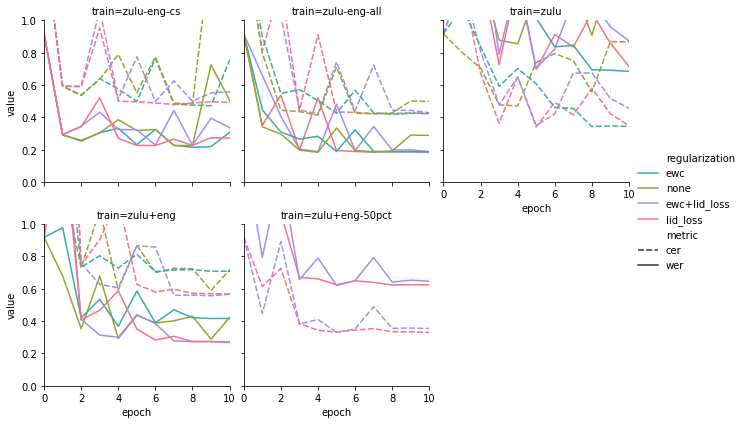

In [131]:
df['beam']=df['beam'].fillna(0).astype(float)
df['lm_alpha']=df['lm_alpha'].astype(str)
g = sb.FacetGrid(
    df[
        # (df['experiment_name'].str.contains('zulu')) &
        # ~(df['experiment_name'].str.contains('zulu-swahili-eng')) &
        (~df['experiment_name'].str.contains('tira')) &
        (~df['train_data'].str.contains('20-80'))&
        (~df['train_data'].str.contains('misc'))&
        # (df['train_data'].str.contains('zulu-eng'))&
        (df['train_data']!='tira-all')&
        # (df['lang_prompt']=='swahili') &
        # (df['lang_prompt']=='croatian')&
        # (df['dataset'].isin(['fl_en', 'tira-clean-split', 'sasoc-cs', 'nchlt_zul'])) &
        (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
        (df['ewc_lambda'].isin([0,1])) &
        (df['lid_loss_alpha'].isin([0,0.2])) &
        # (df['beam']==2)&
        (df['beam']==0)&
        # (df['regularization']=='none')&
        # (df['tag'].str.contains('loss'))
        # (df['tag']=='train/loss')
        (df['metric']!='')
        # (df['LoRA'])
    ],
    # col='ewc_lambda',
    col='train_data',
    col_wrap=3,
    # row='lm_alpha',
    # col='lid_loss_alpha',
    # row='beam',
    # row='dataset',
    # sharey=False,
)
palette_map= {
    key: color for key, color in
    zip(['lid_loss', 'none', 'ewc', 'ewc+lid_loss'], sb.color_palette('husl',4))
}
g.map_dataframe(
    sb.lineplot,
    x='epoch',
    # x='step',
    y='value',
    # y='loss_diff',
    # hue='lid_loss_alpha',
    hue='regularization',
    palette=palette_map,
    # hue='ewc_lambda',
    # errorbar=None,
    legend='full',
    style='metric',
    # style='tag',
)
# g.set_titles('eval={row_name}, train={col_name}')
g.set_titles('train={col_name}')
g.add_legend()
# g.set_title('Performance on English while decoding as Yoruba')
g.set(ylim=(0,1))
g.set(xlim=(0,10))
plt.show()

In [129]:
df.loc[df['experiment_name']=='whisper-small-tira-ewc-lambda-1','metric'].unique()

array(['', 'cer', 'wer'], dtype=object)

In [207]:
indices = []
def epoch_at_min_value(col):
    # print(type(col))
    # print(col.index)
    indices.extend(col.index)
    df_slice = df.loc[col.index]
    # print(df_slice['experiment_name'].unique())
    # print(df_slice['tag'].unique())
    # min_val_idx = df_slice.loc[df_slice['metric']=='wer','value'].idxmin()
    min_val_idx = df_slice['value'].idxmin()
    return df_slice.at[min_val_idx, 'epoch']


metric_cols = df[
    (df['metric']!='')&
    (df['epoch']<=10)&
    # (df['epoch']>1)&
    (~df['train_data'].str.contains('20-80'))&
    (df['train_data']!='tira-all')&
    (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
    (~df['train_data'].str.contains('misc')) &
    (df['step']!=5450)
].pivot_table(
    columns=['regularization'],
    values=['value'],
    index=['train_data', 'epoch', 'metric'],
    aggfunc=lambda x:(print(x),x.item()),
)

# table = metric_cols\
#     .droplevel(axis=1, level=0)\
#     .sort_values('wer')\
#     .reset_index()\
#     .drop_duplicates(
#         subset=['train_data', 'regularization'],
#         keep='first',
#     )\
#     .set_index(['train_data'])\
#     .rename_axis('', axis=1)\
#     .sort_index()\
#     .pivot_table(
#         columns='regularization',
#         values=['cer', 'wer'],
#         index=['train_data', 'epoch']
#     )
metric_cols

3610    0.511096
Name: value, dtype: float64
3878    0.511096
Name: value, dtype: float64
3744    0.511096
Name: value, dtype: float64
0    0.511096
Name: value, dtype: float64
3665    0.637496
Name: value, dtype: float64
3933    0.637496
Name: value, dtype: float64
3799    0.637496
Name: value, dtype: float64
55    0.637496
Name: value, dtype: float64
3611    0.835037
Name: value, dtype: float64
3879    0.843174
Name: value, dtype: float64
3745    0.756288
Name: value, dtype: float64
1    0.736247
Name: value, dtype: float64
3666    1.087869
Name: value, dtype: float64
3934    0.894699
Name: value, dtype: float64
3800    0.895767
Name: value, dtype: float64
56    0.865884
Name: value, dtype: float64
3612    0.764963
Name: value, dtype: float64
3880    0.689711
Name: value, dtype: float64
3746    0.714324
Name: value, dtype: float64
2    0.69267
Name: value, dtype: float64
3667    0.940591
Name: value, dtype: float64
3935    0.787264
Name: value, dtype: float64
3801    0.802917
Name: v

ValueError: can only convert an array of size 1 to a Python scalar

In [208]:
df.loc[[9789,9790]]

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
9789,9.0,6291,eval/sasoc-cs-en+sw_cer,0.272616,whisper-small-zulu-swahili-eng-lid-alpha-0.2-e...,1900-02-11 23:46:04,NaN,NaN,0.2,False,...,nan,0.0,9,cer,sasoc-cs,True,True,ewc+lid_loss,zulu+eng,NaN
9790,10.0,6980,eval/sasoc-cs-en+sw_cer,0.274279,whisper-small-zulu-swahili-eng-lid-alpha-0.2-e...,1900-02-11 23:46:04,NaN,NaN,0.2,False,...,nan,0.0,9,cer,sasoc-cs,True,True,ewc+lid_loss,zulu+eng,NaN


In [211]:
6980/546

12.783882783882785

In [183]:
df.loc[
    (df['experiment_name']=='whisper-small-zulu-swahili-lid-alpha-0.2-ewc-lambda-1')&
    (df['metric']!=''),
    'step'
].unique()

array([    0,   546,  1092,  1638,  2184,  2730,  3276,  3822,  4368,
        4914,  5450,  5460,  6006,  6552,  7098,  7644,  8190,  8736,
        9282,  9828, 10374, 10920, 11466, 12012, 12558, 13104, 13650,
       14196, 14742, 15288, 15834, 16380])